<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snowmelt_prediction_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
""
# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)


df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


In [4]:
features = ['Date',"Q","SCA","T",'P']
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [5]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [6]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

df_snow_melting

<ipython-input-6-164b30e8e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T,P
0,2001-01-01,2.69,345.815123,-4.169740,0.000000
1,2001-01-02,2.53,343.608727,-4.142604,0.000000
2,2001-01-03,2.53,341.437417,-5.148725,0.000000
3,2001-01-04,2.43,339.336277,-6.523695,0.031144
4,2001-01-05,2.53,337.340394,-6.860106,0.000000
...,...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230,0.000000
4013,2012-12-27,2.91,219.264614,-5.501225,0.000000
4014,2012-12-28,3.03,210.043412,-5.526874,0.000000
4015,2012-12-29,2.97,201.080703,-5.107484,0.000000


In [7]:
import pandas as pd
import numpy as np

# data scaled

df_input = df_snow_melting[['Q','SCA', 'T']]


def min_max_scaling(data):
    # Subtract the minimum value and divide by the range
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

# Assuming df_snow_melting is your DataFrame
columns_to_scale = ['Q', 'SCA', 'T']
scaled_df = df_input.copy()

# Apply min-max scaling to specified columns
for column in columns_to_scale:
    scaled_df[column], _, _ = min_max_scaling(df_input[column])

# Print the scaled DataFrame
print(scaled_df)


             Q       SCA         T
0     0.087577  0.851791  0.302737
1     0.080424  0.844592  0.304062
2     0.080424  0.837508  0.254949
3     0.075953  0.830653  0.187831
4     0.080424  0.824141  0.171409
...        ...       ...       ...
4012  0.097412  0.469406  0.230419
4013  0.097412  0.438898  0.237742
4014  0.102776  0.408812  0.236490
4015  0.100094  0.379570  0.256962
4016  0.097412  0.351593  0.261586

[4017 rows x 3 columns]


In [8]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(scaled_df,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [10]:
!pip install hydroeval

In [11]:
import hydroeval as he

In [11]:
from tcn import TCN

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
import kerastuner as kt
from tensorflow import keras

from tensorflow.keras.metrics import MeanAbsoluteError




from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters




# Define the TCN regression model
def create_tcn_regression_model(hp):
    input_layer = Input(shape=input_shape)

    # Choose the number of TCN layers
    num_tcn_layers = hp.Int('num_tcn_layers', min_value=1, max_value=3, default=2)

    tcn_layers = []
    for i in range(num_tcn_layers):
        tcn_layer = TCN(
            nb_filters=hp.Int(f'nb_filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[2, 3, 4]),
            dilations=[1, 2, 4, 8],
            return_sequences=True if i < num_tcn_layers - 1 else False
        )(input_layer)
        tcn_layers.append(tcn_layer)

    output_layer = Dense(1, activation='linear')(tcn_layers[-1])
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Choose an optimizer based on hyperparameter search space
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate,beta_1=0.9, beta_2=0.999)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])

    return model



# Define the input shape based on your data
input_shape = X.shape[1:]

# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Assume you have your data X and y
best_model = None


# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    # best_model_inner = None
    # best_score_inner = float('inf')  # Initialize with a high value

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        # Initialize Keras Tuner
        tuner = RandomSearch(
            create_tcn_regression_model,
            objective='val_loss',
            max_trials=15,
            directory=f'/content/drive/MyDrive/research/tcn/keras_tuner_random_dir_fold_tcn_{fold_outer_idx}_{fold_idx}',
            project_name=f'/content/drive/MyDrive/research/tcn/keras_tuner_random_dir_fold_tcn_{fold_outer_idx}_{fold_idx}/hyperparameter_random_tuning_fold_tcn_{fold_outer_idx}_{fold_idx}'
        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = create_tcn_regression_model(best_hps)
        es = EarlyStopping(patience=10, restore_best_weights=True)

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)

        # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best model, evaluate it on the test set
        # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    nse_best = he.evaluator(he.nse, y_pred_best, y_test_outer)
    kge_best, r, alpha, beta = he.evaluator(he.kge, y_pred_best, y_test_outer)
    print("Best Model:")
    print("KGE : ", kge_best)

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    nse_worst = he.evaluator(he.nse, y_pred_worst, y_test_outer)
    kge_worst, r, alpha, beta = he.evaluator(he.kge, y_pred_worst, y_test_outer)
    print("Worst Model:")
    print("KGE : ", kge_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
            "nse": nse_best,
            "kge": kge_best
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
            "nse": nse_worst,
            "kge": kge_worst
        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)


Trial 15 Complete [00h 00m 43s]
val_loss: 0.000608697475399822

Best val_loss So Far: 0.0005468848394230008
Total elapsed time: 00h 13m 08s
Best hyperparameters for fold 2: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b7e08059360>
Epoch 1/100
67/67 [==============================] - 3s 21ms/step - loss: 0.6791 - mae: 0.3509 - val_loss: 0.0050 - val_mae: 0.0530
Epoch 2/100
67/67 [==============================] - 1s 15ms/step - loss: 0.0434 - mae: 0.1395 - val_loss: 0.0250 - val_mae: 0.1487
Epoch 3/100
67/67 [==============================] - 1s 15ms/step - loss: 0.0141 - mae: 0.0900 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 4/100
67/67 [==============================] - 2s 23ms/step - loss: 0.0045 - mae: 0.0490 - val_loss: 0.0092 - val_mae: 0.0808
Epoch 5/100
67/67 [==============================] - 2s 24ms/step - loss: 0.0029 - mae: 0.0385 - val_loss: 0.0019 - val_mae: 0.0359
Epoch 6/100
67/67 [==============================] - 2s 24ms/step - l

In [13]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}, time: {scores['Best Model']['testing time']}")


Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0007241146440224053, R^2: 0.9877656422154603, RMSE: 0.026909378365588554, MAE: 0.012285584821755558, kge: [0.98068186], nse: [0.98776564], time: 0.9055726528167725

Fold 2 - MSE: 0.0004714981474865988, R^2: 0.9918651046401022, RMSE: 0.021714008093546407, MAE: 0.01081901144325871, kge: [0.98913269], nse: [0.9918651], time: 0.9028289318084717

Fold 3 - MSE: 0.0004953340975462518, R^2: 0.9913187308364029, RMSE: 0.022256102478786618, MAE: 0.011330145059992948, kge: [0.98652537], nse: [0.99131873], time: 0.48664402961730957

Fold 4 - MSE: 0.0005222029897221468, R^2: 0.9915334415788396, RMSE: 0.022851761195193398, MAE: 0.011532589070261801, kge: [0.9888332], nse: [0.99153344], time: 0.6611597537994385

Fold 5 - MSE: 0.0004040983332428062, R^2: 0.9931128293588193, RMSE: 0.020102197224254024, MAE: 0.010434293297953586, kge: [0.99048374], nse: [0.99311283], time: 0.549278974533081


In [14]:

# # After the nested cross-validation, you can analyze and compare the results for different folds
# for fold, scores in enumerate(nested_scores):
#     print(f"Fold {fold + 1} - MSE: {scores['MSE']:.3f}, MAE: {scores['MAE']:.3f},RMSE: {scores['RMSE']:.3f}, R^2: {scores['R^2']:.3f}")

# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Mean MSE: 0.001
Mean MAE: 0.011
Mean RMSE: 0.023
Mean R^2: 0.991
Mean kge: 0.987
Mean nse: 0.991
Mean time: 0.701


126/126 [==============================] - 1s 5ms/step


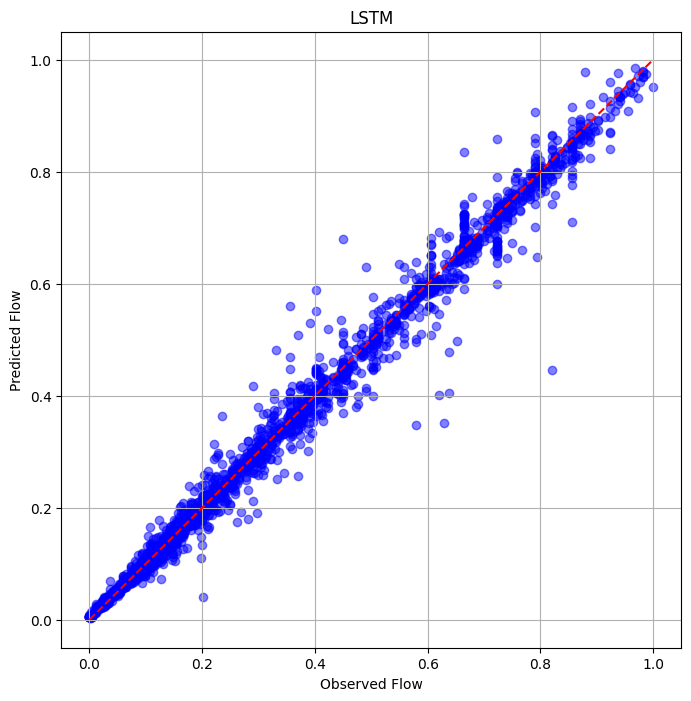

In [15]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('LSTM')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()


In [16]:
# Assuming best_model is your final trained model
best_model.save('/content/drive/MyDrive/research/tcn/best_model_tcn.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


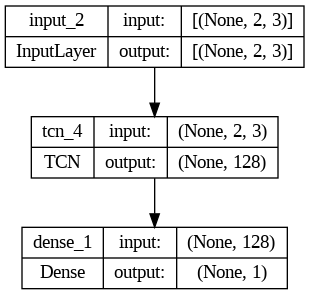

In [17]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tcn_model.png', show_shapes=True, show_layer_names=True)

In [18]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)


Optimizer: RMSprop
Learning Rate: 0.0015674105379730463


In [19]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")


Dropout Rates:


In [12]:
from keras.models import load_model
import tensorflow as tf

# Load the saved model with custom_objects
loaded_model = load_model('/content/drive/MyDrive/research/tcn/best_model_tcn.h5', custom_objects={'TCN': TCN})


In [14]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 3)]            0         
                                                                 
 tcn_4 (TCN)                 (None, 128)               231680    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 231809 (905.50 KB)
Trainable params: 231809 (905.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Extract hyperparameters
num_tcn_layers = sum(1 for layer in loaded_model.layers if isinstance(layer, TCN))
num_filters = loaded_model.get_config()['layers'][0]['config']# Adjust the layer index accordingly
kernel_size = loaded_model.get_config()['layers'][0]['config'] # Adjust the layer index accordingly
# Add other hyperparameters as needed

# Print hyperparameters
print("Number of TCN Layers:", num_tcn_layers)
print("Number of Filters:", num_filters)
print("Kernel Size:", kernel_size)
# Print other hyperparameters

Number of TCN Layers: 1
Number of Filters: {'batch_input_shape': (None, 2, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}
Kernel Size: {'batch_input_shape': (None, 2, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}
